In [1]:
ON_COLAB = True
USE_DRIVE = False

In [2]:
if ON_COLAB:
    # ----- for colab
    !gdown 1TkdWr42pf3BN02xW9diBcldNsC7NYpNd
    !gdown 124jEoZmjnAlXm73RsMBNJZbl6e5F24pR

    from zipfile import ZipFile

    with ZipFile("images.zip", 'r') as zObject:
        zObject.extractall(path="dataset")

    with ZipFile("annotations.zip", 'r') as zObject:
        zObject.extractall(path="dataset")


Downloading...
From (original): https://drive.google.com/uc?id=1TkdWr42pf3BN02xW9diBcldNsC7NYpNd
From (redirected): https://drive.google.com/uc?id=1TkdWr42pf3BN02xW9diBcldNsC7NYpNd&confirm=t&uuid=74470ec9-61ea-43f7-aab0-8b514a7273d3
To: /content/images.zip
100% 792M/792M [00:20<00:00, 39.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=124jEoZmjnAlXm73RsMBNJZbl6e5F24pR
To: /content/annotations.zip
100% 18.1k/18.1k [00:00<00:00, 43.1MB/s]


In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt


In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        if USE_DRIVE:
            self.root = Path("drive") / "MyDrive" / "Colab Notebooks" / "cv" / "dataset"
        elif ON_COLAB:
            self.root = Path("dataset")
        else:
            self.root = Path("/home/liam/Desktop/magistrale/computervision/progetto/modulo_due/ipcv-assignment-2/dataset")
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [5]:
import random
from torchvision import transforms
from torchvision.transforms import functional as tF

class Random90DegreeRotation:
    """Custom transform for 90-degree rotations with specific probabilities."""
    def __call__(self, img):
        prob = random.random()
        if prob < 0.5:
            return img  # No rotation
        elif prob < 0.75:
            return tF.rotate(img, angle=-90)  # Rotate 90 degrees left
        else:
            return tF.rotate(img, angle=90)  # Rotate 90 degrees right

class OuterRandomCrop:
    """Custom transform to randomly crop the same amount of pixels from each side of the image."""
    def __init__(self, max_pixels_to_crop):
        """
        Args:
            max_pixels_to_crop (int): The maximum number of pixels to subtract from each side of the image.
        """
        self.max_pixels_to_crop = max_pixels_to_crop

    def __call__(self, img):
        # decides whether to apply the crop (75% chance)
        if random.random() < 0.25:
            return img

        # randomly select the number of pixels to crop (between 0 and max_pixels_to_crop)
        pixels_to_crop = random.randint(0, self.max_pixels_to_crop)

        width, height = img.size
        crop_left = pixels_to_crop
        crop_top = pixels_to_crop
        crop_width = width - 2 * pixels_to_crop
        crop_height = height - 2 * pixels_to_crop

        if crop_width <= 0 or crop_height <= 0:
            raise ValueError("The number of pixels to crop is too large for the image dimensions.")

        return tF.crop(img, top=crop_top, left=crop_left, height=crop_height, width=crop_width)


convert_compatible = transforms.Compose([
    transforms.Resize((224, 224)),     # Deterministic resize
    transforms.ToTensor(),             # Format conversion only
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # image net normalization values
])

transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),       # Random horizontal flip
    OuterRandomCrop(20),                 # Custom outer crop
    Random90DegreeRotation(),                    # Custom 90-degree rotation
    transforms.RandomRotation(10),              # Random rotation of ±10 degrees
    transforms.ColorJitter(brightness=0.4),      # Adjust brightness slightly
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

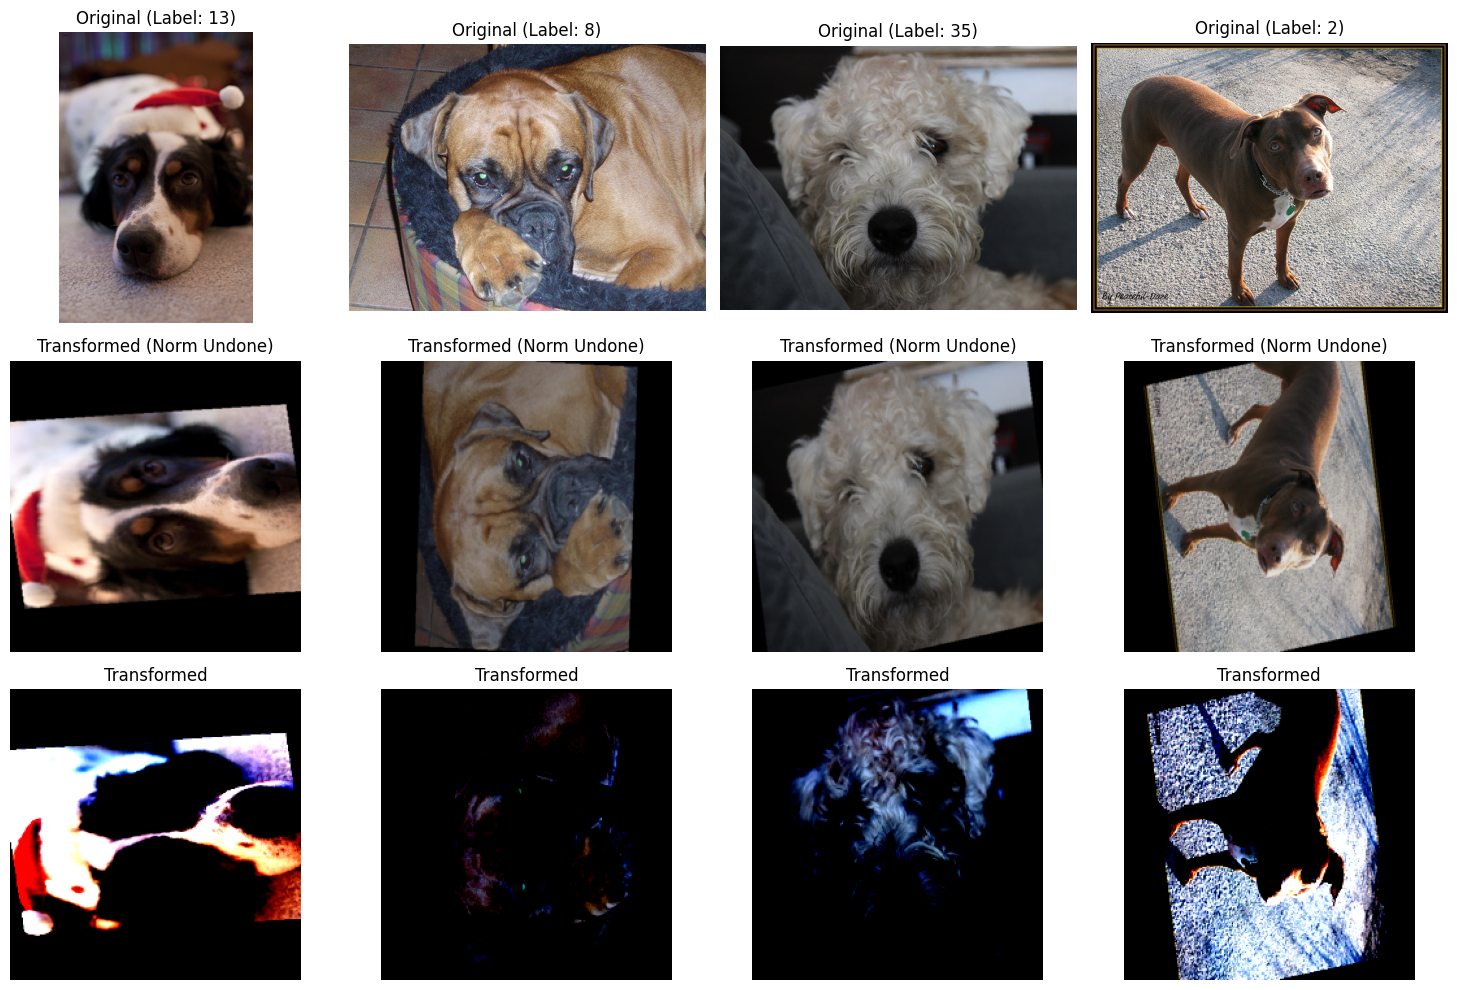

In [6]:
import matplotlib.pyplot as plt
import random

# Function to display images
def display_image_comparison(dataset, num_images=4):
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))  # 3 rows, num_images columns

    for i in range(num_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)

        # Access the raw image without applying the dataset's transform
        img_path = dataset.root / "images" / f"{dataset.names[idx]}.jpg"
        original_img = Image.open(img_path).convert("RGB")  # Load as PIL image
        label = dataset.labels[idx]

        # Apply your transformation
        transformed_with_norm = transform_data_augmentation(original_img)  # Fully transformed with normalization

        # Undo normalization for visualization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transformed_with_norm_np = transformed_with_norm.permute(1, 2, 0).numpy()
        transformed_no_norm_np = std * transformed_with_norm_np + mean  # Undo normalization
        transformed_no_norm_np = transformed_no_norm_np.clip(0, 1)

        # Display original image
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis("off")

        # Display transformed image with normalization undone
        axes[1, i].imshow(transformed_no_norm_np)
        axes[1, i].set_title("Transformed (Norm Undone)")
        axes[1, i].axis("off")

        # Display fully transformed image (with normalization)
        axes[2, i].imshow(transformed_with_norm_np)
        axes[2, i].set_title("Transformed")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display the comparison
display_image_comparison(train_dataset, num_images=4)

In [7]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    show_all_minibatches_loss=False,
    lr_scheduler_fn=None  # Function to calculate the next learning rate
):
    """
    Trains a PyTorch model and evaluates it on a validation set.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function to optimize.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        num_epochs (int): Number of epochs to train the model.
        show_all_minibatches_loss (bool): Can be 'no', 'brief', 'verbose'. Determines how many mini batch losses are printed
        lr_scheduler_fn (callable, optional): Function to adjust the learning rate based on a metric (validation accuracy).

    Returns:
        tuple: A tuple containing:
            - train_losses (list): List of average training losses per epoch.
            - train_accuracies (list): List of training accuracies per epoch.
            - train_class_accuracies (list): List of per-class training accuracies per epoch.
            - val_losses (list): List of validation losses per epoch.
            - val_accuracies (list): List of validation accuracies per epoch.
            - val_class_accuracies (list): List of per-class validation accuracies per epoch.
    """

    train_losses = []
    train_accuracies = []
    train_class_accuracies = []
    val_losses = []
    val_accuracies = []
    val_class_accuracies = []

    # Get number of classes from the model's output layer
    num_classes = model.fc.out_features

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Initialize per-class counters for training
        train_class_correct = torch.zeros(num_classes, dtype=torch.long)
        train_class_total = torch.zeros(num_classes, dtype=torch.long)

        tot_batches = train_loader.__len__()
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            if show_all_minibatches_loss != 'no':
                if show_all_minibatches_loss == 'verbose' or batch_idx in [40, 80]:
                    print(f"Batch {batch_idx + 1}/{tot_batches}: loss = {loss.item():.4f}")

            # Compute gradients
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()

            # Per-class accuracy for training
            for i in range(batch_labels.size(0)):
                label = batch_labels[i]
                train_class_total[label] += 1
                if predicted[i] == label:
                    train_class_correct[label] += 1

        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Calculate per-class accuracies for training
        epoch_train_class_accuracies = []
        for i in range(num_classes):
            if train_class_total[i] > 0:
                class_acc = train_class_correct[i].item() / train_class_total[i].item()
            else:
                class_acc = 0.0  # No samples for this class in training set
            epoch_train_class_accuracies.append(class_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Initialize per-class counters for validation
        val_class_correct = torch.zeros(num_classes, dtype=torch.long)
        val_class_total = torch.zeros(num_classes, dtype=torch.long)

        with torch.no_grad():  # Doesn't compute gradients for validation
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_images)
                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

                # Per-class accuracy for validation
                for i in range(batch_labels.size(0)):
                    label = batch_labels[i]
                    val_class_total[label] += 1
                    if predicted[i] == label:
                        val_class_correct[label] += 1

        val_accuracy = 100 * correct_val / total_val
        val_loss = running_val_loss / len(val_loader)

        # Calculate per-class accuracies for validation
        epoch_val_class_accuracies = []
        for i in range(num_classes):
            if val_class_total[i] > 0:
                class_acc = val_class_correct[i].item() / val_class_total[i].item()
            else:
                class_acc = 0.0  # No samples for this class in validation set
            epoch_val_class_accuracies.append(class_acc)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_class_accuracies.append(epoch_train_class_accuracies)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(epoch_val_class_accuracies)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Adjust learning rate using the scheduler function
        if lr_scheduler_fn is not None:
            new_lr = lr_scheduler_fn(optimizer.param_groups[0]['lr'], val_accuracies)
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr # we only modify the learning rate in the optimizer we chose

        print('-'*20)

    return train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies



def val_accuracy_scheduler(current_lr, val_accuracies, patience=5, decay_factor=0.5):
    """
    Adjusts the learning rate based on validation accuracy.

    Args:
        current_lr (float): Current learning rate.
        val_accuracies (list): List of validation accuracies from previous epochs.
        patience (int): Number of epochs to wait for improvement before reducing the learning rate.
        decay_factor (float): Factor by which to reduce the learning rate.

    Returns:
        float: New learning rate.
    """
    if len(val_accuracies) > patience:
        recent_accuracies = val_accuracies[-patience:]
        if max(recent_accuracies) <= val_accuracies[-(patience + 1)]:
            new_lr = current_lr * decay_factor
            print(f"Learning rate adjusted to: {new_lr}")
            return new_lr
    return current_lr

# resnet model

è cambiato rispetto a quella fpn se che la reduction dei blochi SE è 4 invece di 16

inoltre, i blocchi SE vengono applicati all'interno dei basic block subito prima dell'addizione residuale, non più in fondo alla rete dopo la fusione piramidale degli strati laterali

In [8]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation block per aumentare l'efficacia della FPN."""
    def __init__(self, channels, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class BasicBlock(nn.Module):
    """Blocco residuale standard per ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.se = SEBlock(out_channels)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        out += identity
        out = self.relu(out)
        return out

class ResNetFPN(nn.Module):
    """ResNet integrata con Feature Pyramid Network."""
    def __init__(self, block, layers, num_classes=37, in_channels=8, fpn_channels=32):
        super(ResNetFPN, self).__init__()
        # Variabili di base
        self.in_channels = in_channels
        self.fpn_channels = fpn_channels

        # Parte iniziale della ResNet
        self.conv1 = nn.Conv2d(3, in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Strati residuali (backbone)
        self.layer1 = self._make_layer(block, in_channels, layers[0])
        self.layer2 = self._make_layer(block, in_channels * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, in_channels * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, in_channels * 8, layers[3], stride=2)

        # FPN lateral connections (conv 1x1 per ridurre i canali a un numero fisso)
        self.lateral_layer1 = nn.Conv2d(in_channels, fpn_channels, kernel_size=1)
        self.lateral_layer2 = nn.Conv2d(in_channels * 2, fpn_channels, kernel_size=1)
        self.lateral_layer3 = nn.Conv2d(in_channels * 4, fpn_channels, kernel_size=1)
        self.lateral_layer4 = nn.Conv2d(in_channels * 8, fpn_channels, kernel_size=1)

        # FPN smooth layers (3x3 conv dopo upsampling per ridurre artefatti)
        self.smooth_layer1 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        self.smooth_layer2 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        self.smooth_layer3 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        self.smooth_layer4 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)

        # Squeeze-Excitation blocks per migliorare l'attenzione sui canali
        self.se1 = SEBlock(fpn_channels)
        self.se2 = SEBlock(fpn_channels)
        self.se3 = SEBlock(fpn_channels)
        self.se4 = SEBlock(fpn_channels)

        # Upsampling per percorso top-down
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Global pooling e classificatore
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(fpn_channels * 4, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Backbone ResNet forward (bottom-up path)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        c1 = self.layer1(x)      # [B, 16, H/4, W/4]
        c2 = self.layer2(c1)     # [B, 32, H/8, W/8]
        c3 = self.layer3(c2)     # [B, 64, H/16, W/16]
        c4 = self.layer4(c3)     # [B, 128, H/32, W/32]

        # FPN Lateral connections - convoluzioni 1x1 per uniformare i canali
        p4 = self.lateral_layer4(c4)               # [B, fpn_channels, H/32, W/32]
        p3 = self.lateral_layer3(c3)               # [B, fpn_channels, H/16, W/16]
        p2 = self.lateral_layer2(c2)               # [B, fpn_channels, H/8, W/8]
        p1 = self.lateral_layer1(c1)               # [B, fpn_channels, H/4, W/4]

        # FPN Top-down pathway con upsampling e somma
        p3 = p3 + self.upsample(p4)                # Combina feature map con livello sopra
        p2 = p2 + self.upsample(p3)                # Combina feature map con livello sopra
        p1 = p1 + self.upsample(p2)                # Combina feature map con livello sopra

        # Smooth layers per ridurre artefatti da upsampling
        p1 = self.smooth_layer1(p1)
        p2 = self.smooth_layer2(p2)
        p3 = self.smooth_layer3(p3)
        p4 = self.smooth_layer4(p4)

        # Global pooling per ogni livello della piramide
        f1 = self.adaptive_pool(p1).squeeze(-1).squeeze(-1)  # [B, fpn_channels]
        f2 = self.adaptive_pool(p2).squeeze(-1).squeeze(-1)  # [B, fpn_channels]
        f3 = self.adaptive_pool(p3).squeeze(-1).squeeze(-1)  # [B, fpn_channels]
        f4 = self.adaptive_pool(p4).squeeze(-1).squeeze(-1)  # [B, fpn_channels]

        # Concatena feature e classifica
        out = torch.cat([f1, f2, f3, f4], dim=1)             # [B, fpn_channels*4]
        return self.fc(out)                                   # [B, num_classes]

def resnet18_fpn_se(num_classes=37):
    return ResNetFPN(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)



num_classes = 37
model_resnet_fpn_se = resnet18_fpn_se(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet_fpn_se = model_resnet_fpn_se.to(device)


from torchsummary import summary
summary(model_resnet_fpn_se, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]           1,176
       BatchNorm2d-2          [-1, 8, 112, 112]              16
              ReLU-3          [-1, 8, 112, 112]               0
         MaxPool2d-4            [-1, 8, 56, 56]               0
            Conv2d-5            [-1, 8, 56, 56]             576
       BatchNorm2d-6            [-1, 8, 56, 56]              16
              ReLU-7            [-1, 8, 56, 56]               0
            Conv2d-8            [-1, 8, 56, 56]             576
       BatchNorm2d-9            [-1, 8, 56, 56]              16
AdaptiveAvgPool2d-10              [-1, 8, 1, 1]               0
           Linear-11                    [-1, 2]              16
             ReLU-12                    [-1, 2]               0
           Linear-13                    [-1, 8]              16
          Sigmoid-14                   

In [9]:
#model_resnet_fpn = resnet18_fpn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_fpn_se.parameters(), lr=0.001)

train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies = train_model(
    model_resnet_fpn_se, train_loader, val_loader, criterion, optimizer, num_epochs=70, show_all_minibatches_loss='no', lr_scheduler_fn=val_accuracy_scheduler
)

Epoch [1/70], Train Loss: 3.5255, Train Acc: 4.99%, Val Loss: 3.8583, Val Acc: 3.54%
--------------------
Epoch [2/70], Train Loss: 3.3505, Train Acc: 7.99%, Val Loss: 3.4617, Val Acc: 7.47%
--------------------
Epoch [3/70], Train Loss: 3.2874, Train Acc: 9.78%, Val Loss: 3.3339, Val Acc: 9.21%
--------------------
Epoch [4/70], Train Loss: 3.2059, Train Acc: 10.63%, Val Loss: 3.2605, Val Acc: 10.31%
--------------------
Epoch [5/70], Train Loss: 3.1330, Train Acc: 13.06%, Val Loss: 3.5731, Val Acc: 9.27%
--------------------
Epoch [6/70], Train Loss: 3.0890, Train Acc: 14.39%, Val Loss: 3.3255, Val Acc: 9.71%
--------------------
Epoch [7/70], Train Loss: 3.0212, Train Acc: 14.94%, Val Loss: 3.0953, Val Acc: 15.27%
--------------------
Epoch [8/70], Train Loss: 2.9659, Train Acc: 17.63%, Val Loss: 3.1894, Val Acc: 14.67%
--------------------
Epoch [9/70], Train Loss: 2.8842, Train Acc: 18.23%, Val Loss: 3.0737, Val Acc: 15.65%
--------------------
Epoch [10/70], Train Loss: 2.8305, T

In [10]:
import os
import pickle



output_dir = "results"

os.makedirs(output_dir, exist_ok=True)

# Save training losses
with open(os.path.join(output_dir, "train_losses_fpn_se_200k.pkl"), "wb") as f:
    pickle.dump(train_losses, f)

with open(os.path.join(output_dir, "train_accuracies_fpn_se_200k.pkl"), "wb") as f:
    pickle.dump(train_accuracies, f)

with open(os.path.join(output_dir, "train_class_accuracies_fpn_se_200k.pkl"), "wb") as f:
    pickle.dump(train_class_accuracies, f)

with open(os.path.join(output_dir, "val_losses_fpn_se_200k.pkl"), "wb") as f:
    pickle.dump(val_losses, f)

with open(os.path.join(output_dir, "val_accuracies_fpn_se_200k.pkl"), "wb") as f:
    pickle.dump(val_accuracies, f)

with open(os.path.join(output_dir, "val_class_accuracies_fpn_se_200k.pkl"), "wb") as f:
    pickle.dump(val_class_accuracies, f)

torch.save(model_resnet_fpn_se, "resnet_18_700k_fpn_se_200k_training_weights")

# Test set accuracy

In [11]:
# Load the saved model weights and map them to the CPU
# model_resnet.load_state_dict(torch.load("resnet_18_complete_training_weights", map_location=torch.device('cpu')))
# model_resnet = model_resnet.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Set the model to evaluation mode
model_resnet_fpn_se.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Move data to the same device as the model
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass: get predictions
        outputs = model_resnet_fpn_se(batch_images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate and print the accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 41.55%


In [12]:
from torchviz import make_dot
from torchsummary import summary
from IPython.display import Image as IpImage

# given model and a file path, saves the image of the architecture of the model
# if successful returns the file path, otherwise returns None
def generate_architecture_image(model, filepath):
    try :
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        output = model(dummy_input) # pass the dummy input through the model

        make_dot(
            output, params=dict(model.named_parameters())) \
            .render(filepath, format="png"
        )
    except:
        return None

    return filepath

ModuleNotFoundError: No module named 'torchviz'

### caso mai la risposta dovesse andare persa


# Analisi del Peggioramento con SE Blocks e Suggerimenti

Il peggioramento dell'accuratezza dopo l'aggiunta dei blocchi Squeeze-and-Excitation è un fenomeno interessante che può avere diverse cause. Ecco un'analisi dei possibili problemi e alcune soluzioni:

## Perché i SE Blocks Peggiorano le Performance

1. **Ratio di Riduzione Troppo Aggressivo**:
   - Nella tua implementazione usi `reduction=16`, che è standard per reti grandi, ma potrebbe essere eccessivo per i tuoi canali ridotti (16-128).
   - Con 16 canali, stai riducendo a solo 1 canale nel collo di bottiglia (16/16=1), troppo poco per catturare relazioni complesse.

2. **Sovraparametrizzazione per Dataset Piccolo**:
   - Con solo 100 immagini per classe, i SE blocks potrebbero introdurre più capacità di modellazione di quanto i dati possano supportare.
   - Anche se aggiungono pochi parametri, hanno un forte impatto sulle feature map.

3. **Posizionamento dei SE Blocks**:
   - Li stai applicando alla fine della FPN, dopo l'upsampling e lo smoothing, dove le feature potrebbero essere già "diluite".
   - Potrebbero essere più efficaci se applicati direttamente ai blocchi residuali.

## Soluzioni Suggerite

1. **Ridurre il Fattore di Riduzione**:
   ```python
   # Prova con un fattore di riduzione più piccolo
   self.se1 = SEBlock(fpn_channels, reduction=4)  # Invece di 16
   ```

2. **Applicare SE Blocks Selettivamente**:
   - Prova ad applicarli solo agli strati più profondi (p3, p4) dove le feature sono più semantiche.
   ```python
   # p1 e p2 senza SE, p3 e p4 con SE
   p3 = self.se3(p3)
   p4 = self.se4(p4)
   ```

3. **Spostare i SE Blocks nei Blocchi Residuali**:
   - Modifica il `BasicBlock` per includere un SE block prima dell'addizione residuale.

4. **Regolarizzazione Aggiuntiva**:
   - Aggiungi dropout o weight decay per contrastare l'overfitting quando usi SE blocks.
   ```python
   # Dopo i SE blocks ma prima del pooling
   p1 = F.dropout(p1, p=0.2, training=self.training)
   ```

## Riguardo la Normalizzazione nel Data Augmentation

La normalizzazione con i valori di ImageNet è una pratica standard e generalmente utile, anche dopo modifiche di luminosità. Ecco alcuni consigli:

1. **Ordine delle Operazioni**:
   - Applica la normalizzazione **dopo** tutte le altre trasformazioni, come stai già facendo.

2. **Range di ColorJitter**:
   - Se le immagini appaiono troppo scure, riduci il range di variazione della luminosità:
   ```python
   transforms.ColorJitter(brightness=0.2)  # Invece di 0.4
   ```

3. **Normalizzazione Personalizzata**:
   - In alternativa, potresti calcolare media e deviazione standard specifiche del tuo dataset:
   ```python
   # Calcola media e std del tuo dataset e usa questi valori invece di quelli di ImageNet
   transforms.Normalize(mean=[0.xx, 0.xx, 0.xx], std=[0.xx, 0.xx, 0.xx])
   ```

## Considerazioni sulla Dimensione del Modello

Con 700k parametri (ResNet) + 600k (FPN) + alcuni migliaia (SE), il modello potrebbe essere ancora troppo grande per 3700 immagini. Considera:

1. **Ridurre Ulteriormente i Canali FPN**:
   ```python
   # Riduci fpn_channels da 128 a 64 o 32
   def __init__(self, block, layers, num_classes=37, fpn_channels=64):
   ```

2. **Semplificare la FPN**:
   - Usa meno livelli nella piramide o un'architettura più semplice.

3. **Aumentare il Data Augmentation**:
   - Tecniche come MixUp o CutMix potrebbero aiutare con dataset piccoli.

Spero che questi suggerimenti ti aiutino a migliorare le performance del tuo modello!